# Import Necessary Libraries

In [1]:
# Data Manipulation and Linear Algebra
import pandas as pd
import numpy as np

# Plots
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

#ignore warning messages 
import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [2]:
data = pd.read_csv("../input/pima-indians-diabetes-database/diabetes.csv")

# Data Overview

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


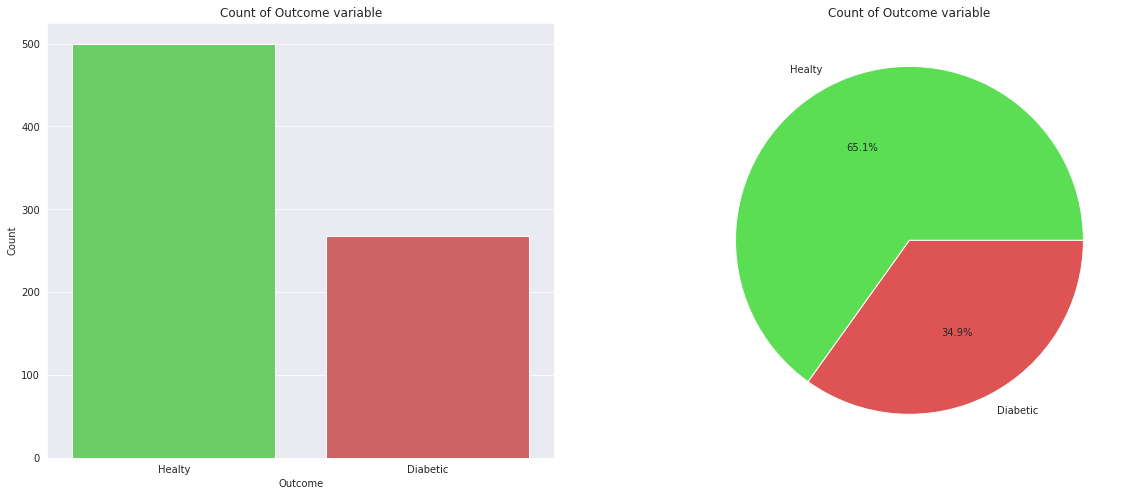

In [5]:
fig, axes = plt.subplots(figsize=(20, 8), nrows=1, ncols=2)

sns.countplot(x="Outcome", data=data, palette=['#5bde54',"#de5454"], ax=axes[0])
axes[0].set_title("Count of Outcome variable")
axes[0].set_ylabel("Count")
axes[0].set_xticklabels(["Healty", "Diabetic"])

plt.pie(data.Outcome.value_counts(), autopct='%.1f%%', labels=["Healty", "Diabetic"], colors=['#5bde54',"#de5454"])
axes[1].set_title("Count of Outcome variable")

plt.show()

## Missing Values

In [6]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


#### As you can see the minimum value for Glucose, BloodPressure, skinThickness, Insulin and BMI is 0 which is practically not possible which suggests us that it is a faulty value.

In [7]:
# Replacing 0 by nan to calculate the null values
data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [8]:
# Missing Values
data.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

#### To fill these Nan values the data distribution needs to be understood against the target.

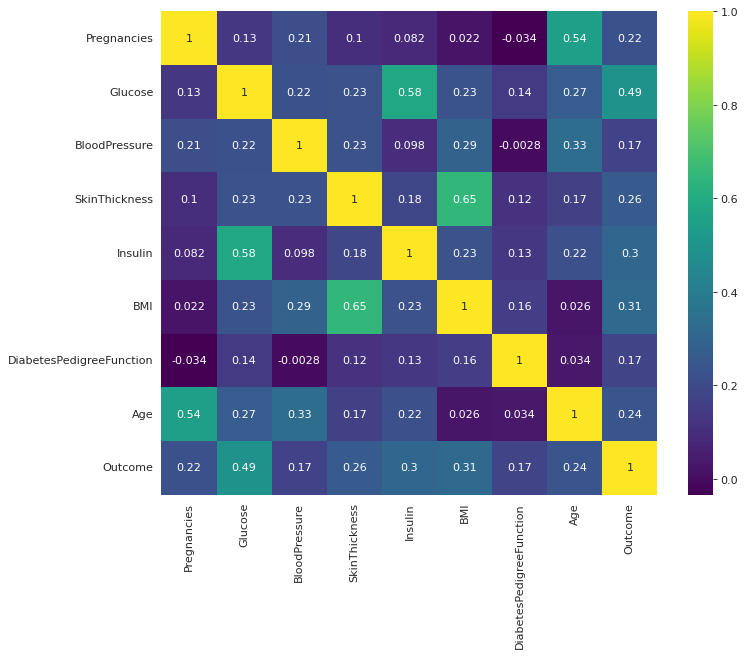

In [9]:
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["figure.dpi"] = 80
sns.heatmap(data.corr(), annot=True, cmap="viridis")
plt.show()

# Replace Missing Values and EDA

In [10]:
def distributon_plot(x):
    fig, axes = plt.subplots(figsize=(20, 8), nrows=1, ncols=2)

    sns.histplot(x=x, hue="Outcome", data=data, palette=['#5bde54',"#de5454"], ax=axes[0])
    axes[0].set_title(f"{x} Distribution Histplot")
    axes[0].legend(["Diabetic", "Healthy"])
    axes[0].set_ylabel("Density / Count")

    sns.kdeplot(x=x, hue="Outcome", data=data, palette=['#5bde54',"#de5454"], ax=axes[1])
    axes[1].set_title(f"{x} Distribution Kdeplot")
    axes[1].legend(["Diabetic", "Healthy"])
    axes[1].set_ylabel("Density / Count")

    plt.show()

In [11]:
# Gets two Median Valuse for Both Outcomes Seprately
def median_target(var):   
    temp = data[data[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

## Insulin

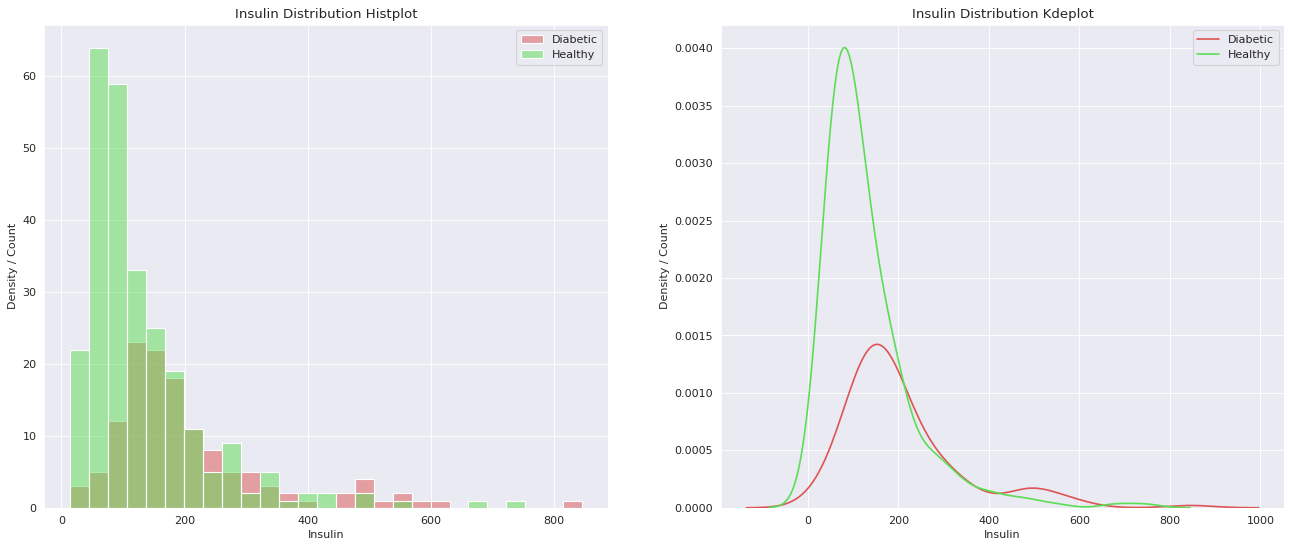

In [12]:
distributon_plot("Insulin")

In [13]:
median_target('Insulin')

,Outcome,Insulin
0,0,102.5
1,1,169.5


#### Insulin's medians by the target are really different ! 102.5 for a healthy person and 169.5 for a diabetic person

In [14]:
data.loc[(data['Outcome'] == 0 ) & (data['Insulin'].isnull()), 'Insulin'] = 102.5
data.loc[(data['Outcome'] == 1 ) & (data['Insulin'].isnull()), 'Insulin'] = 169.5

## Glucose

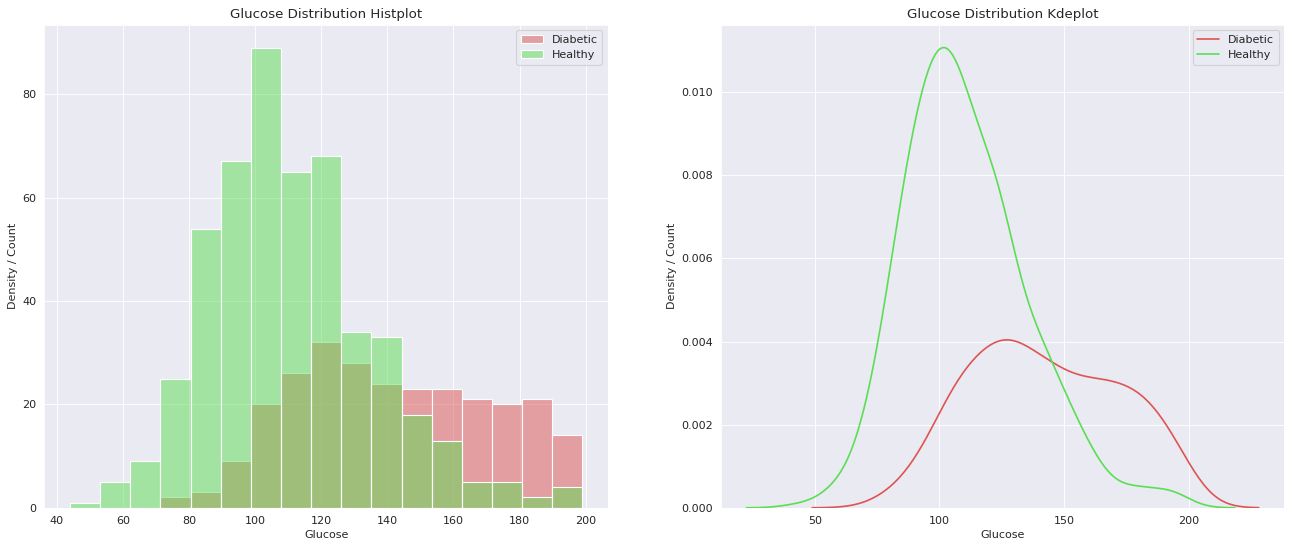

In [15]:
distributon_plot("Glucose")

In [16]:
median_target('Glucose')

,Outcome,Glucose
0,0,107.0
1,1,140.0


In [17]:
data.loc[(data['Outcome'] == 0 ) & (data['Glucose'].isnull()), 'Glucose'] = 107
data.loc[(data['Outcome'] == 1 ) & (data['Glucose'].isnull()), 'Glucose'] = 140

## Skin Thickness

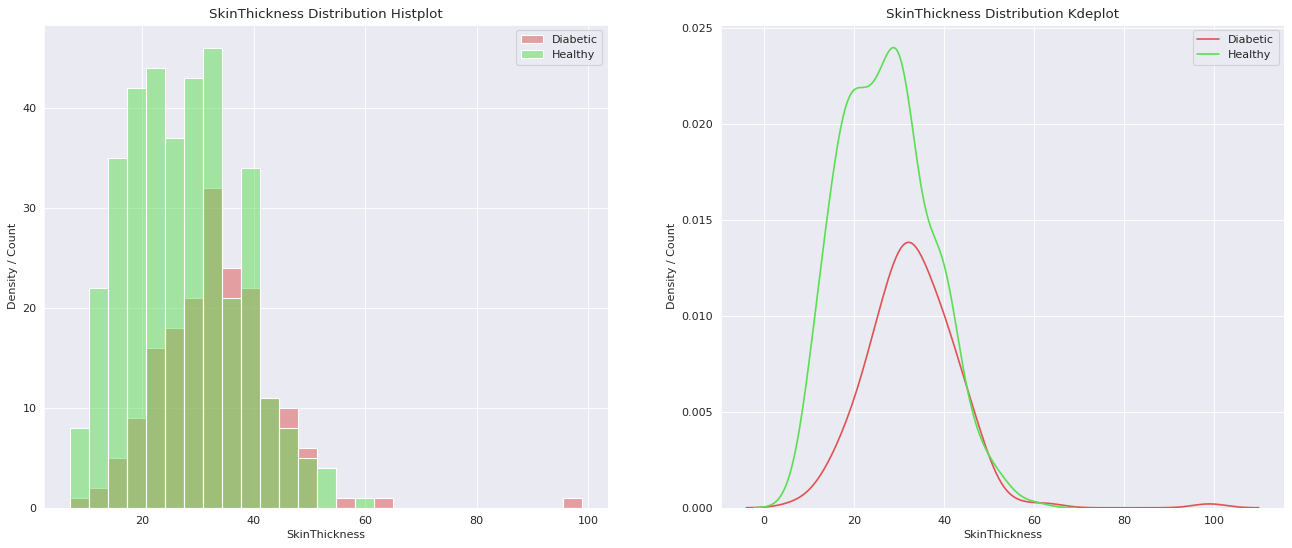

In [18]:
distributon_plot("SkinThickness")

In [19]:
median_target("SkinThickness")

,Outcome,SkinThickness
0,0,27.0
1,1,32.0


In [20]:
data.loc[(data['Outcome'] == 0 ) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 27
data.loc[(data['Outcome'] == 1 ) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 32

## Blood Pressure

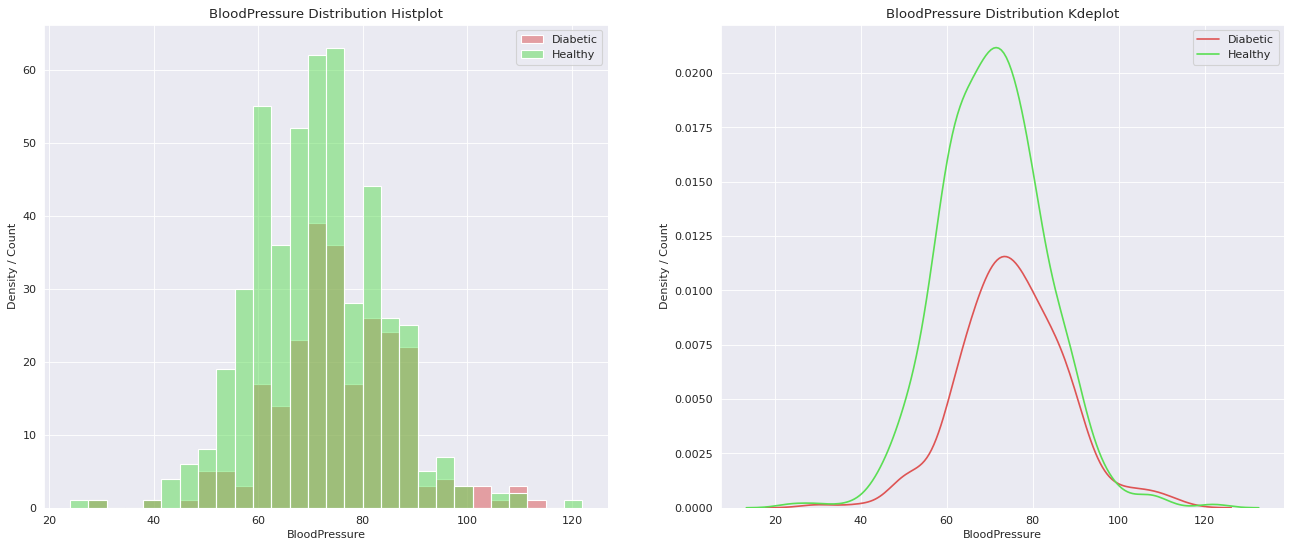

In [21]:
distributon_plot("BloodPressure")

In [22]:
median_target('BloodPressure')

,Outcome,BloodPressure
0,0,70.0
1,1,74.5


In [23]:
data.loc[(data['Outcome'] == 0 ) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 70
data.loc[(data['Outcome'] == 1 ) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 74.5

## BMI

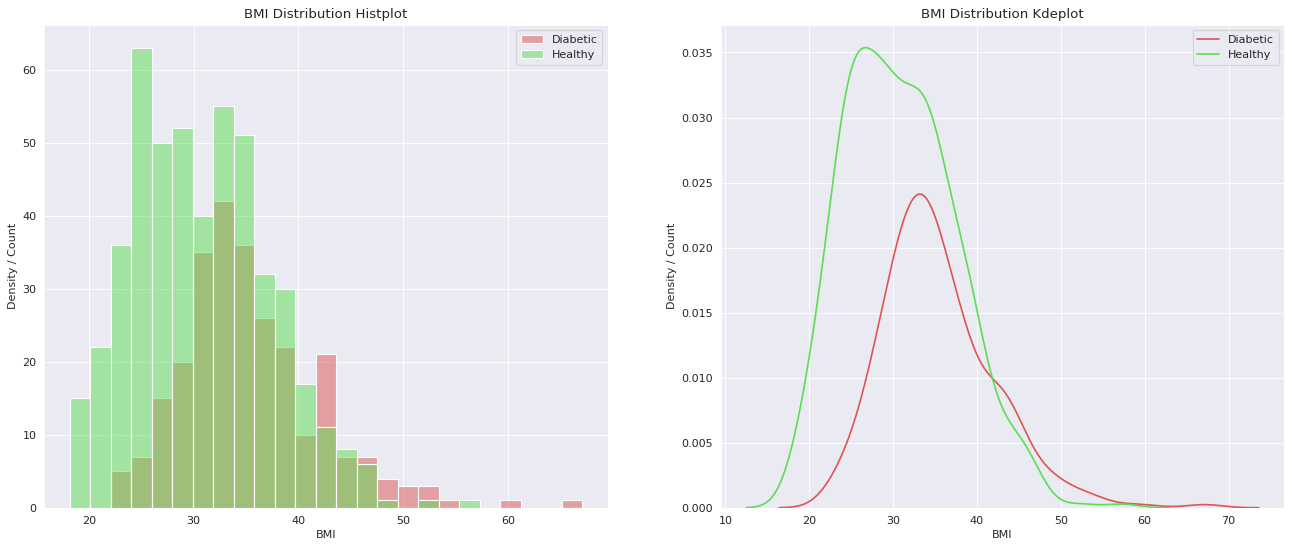

In [24]:
distributon_plot("BMI")

In [25]:
median_target('BMI')

,Outcome,BMI
0,0,30.1
1,1,34.3


In [26]:
data.loc[(data['Outcome'] == 0 ) & (data['BMI'].isnull()), 'BMI'] = 30.1
data.loc[(data['Outcome'] == 1 ) & (data['BMI'].isnull()), 'BMI'] = 34.3

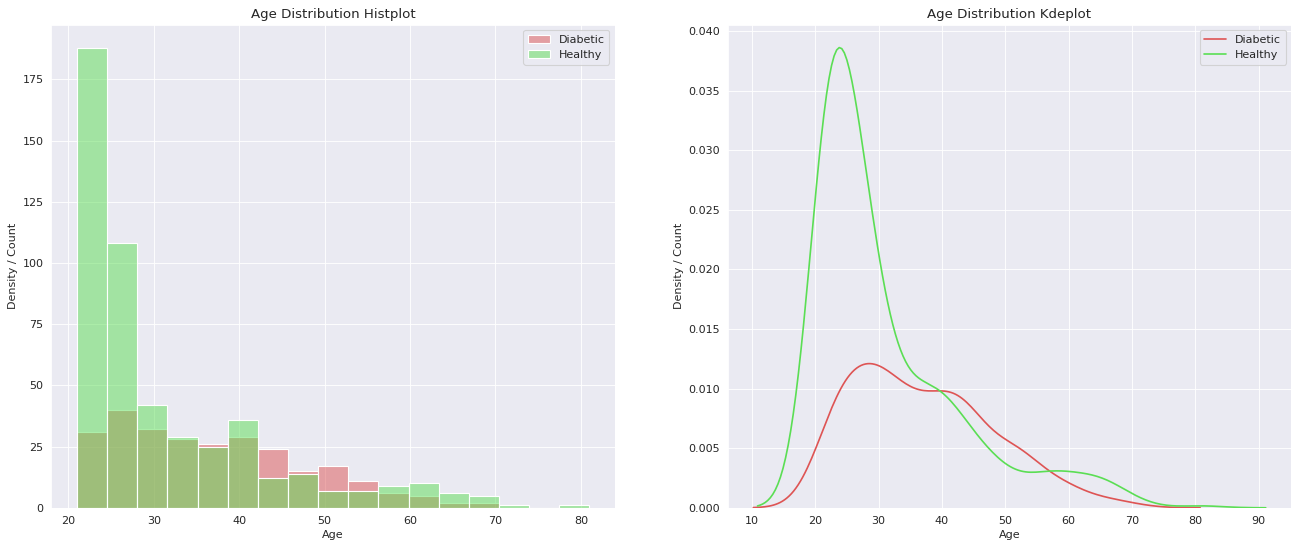

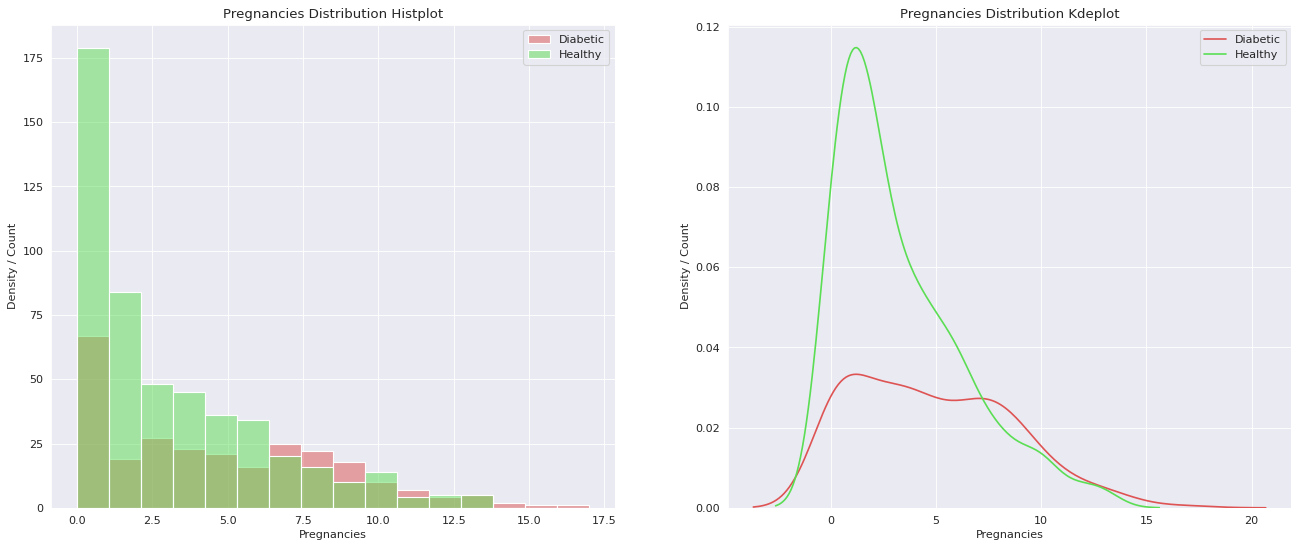

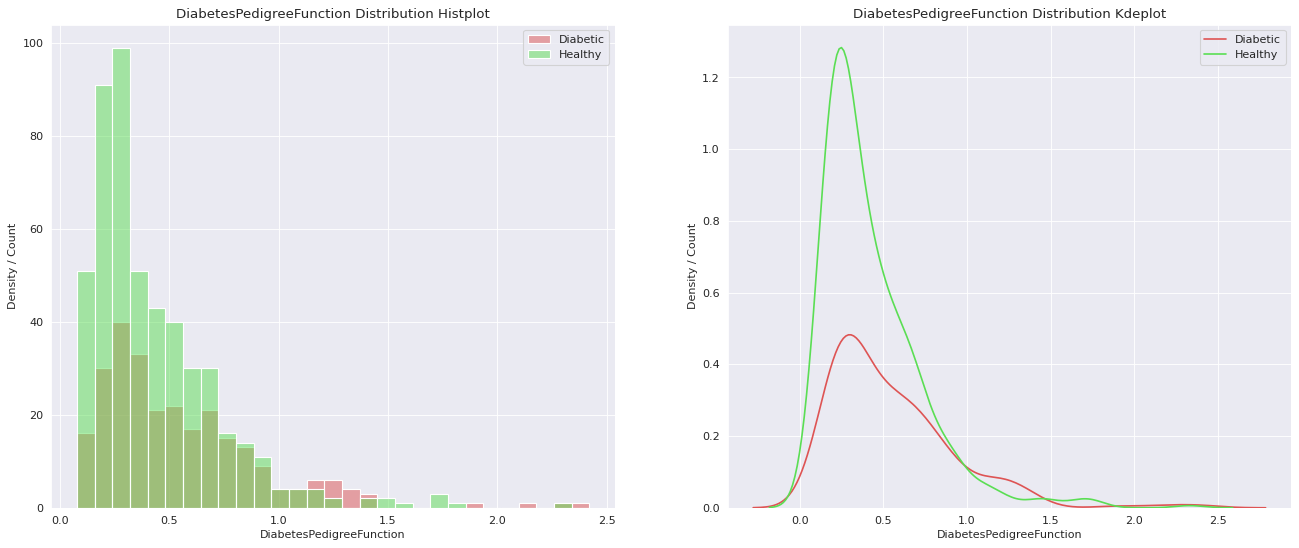

In [27]:
distributon_plot("Age")
distributon_plot("Pregnancies")
distributon_plot("DiabetesPedigreeFunction")

## All Features Pair Plot

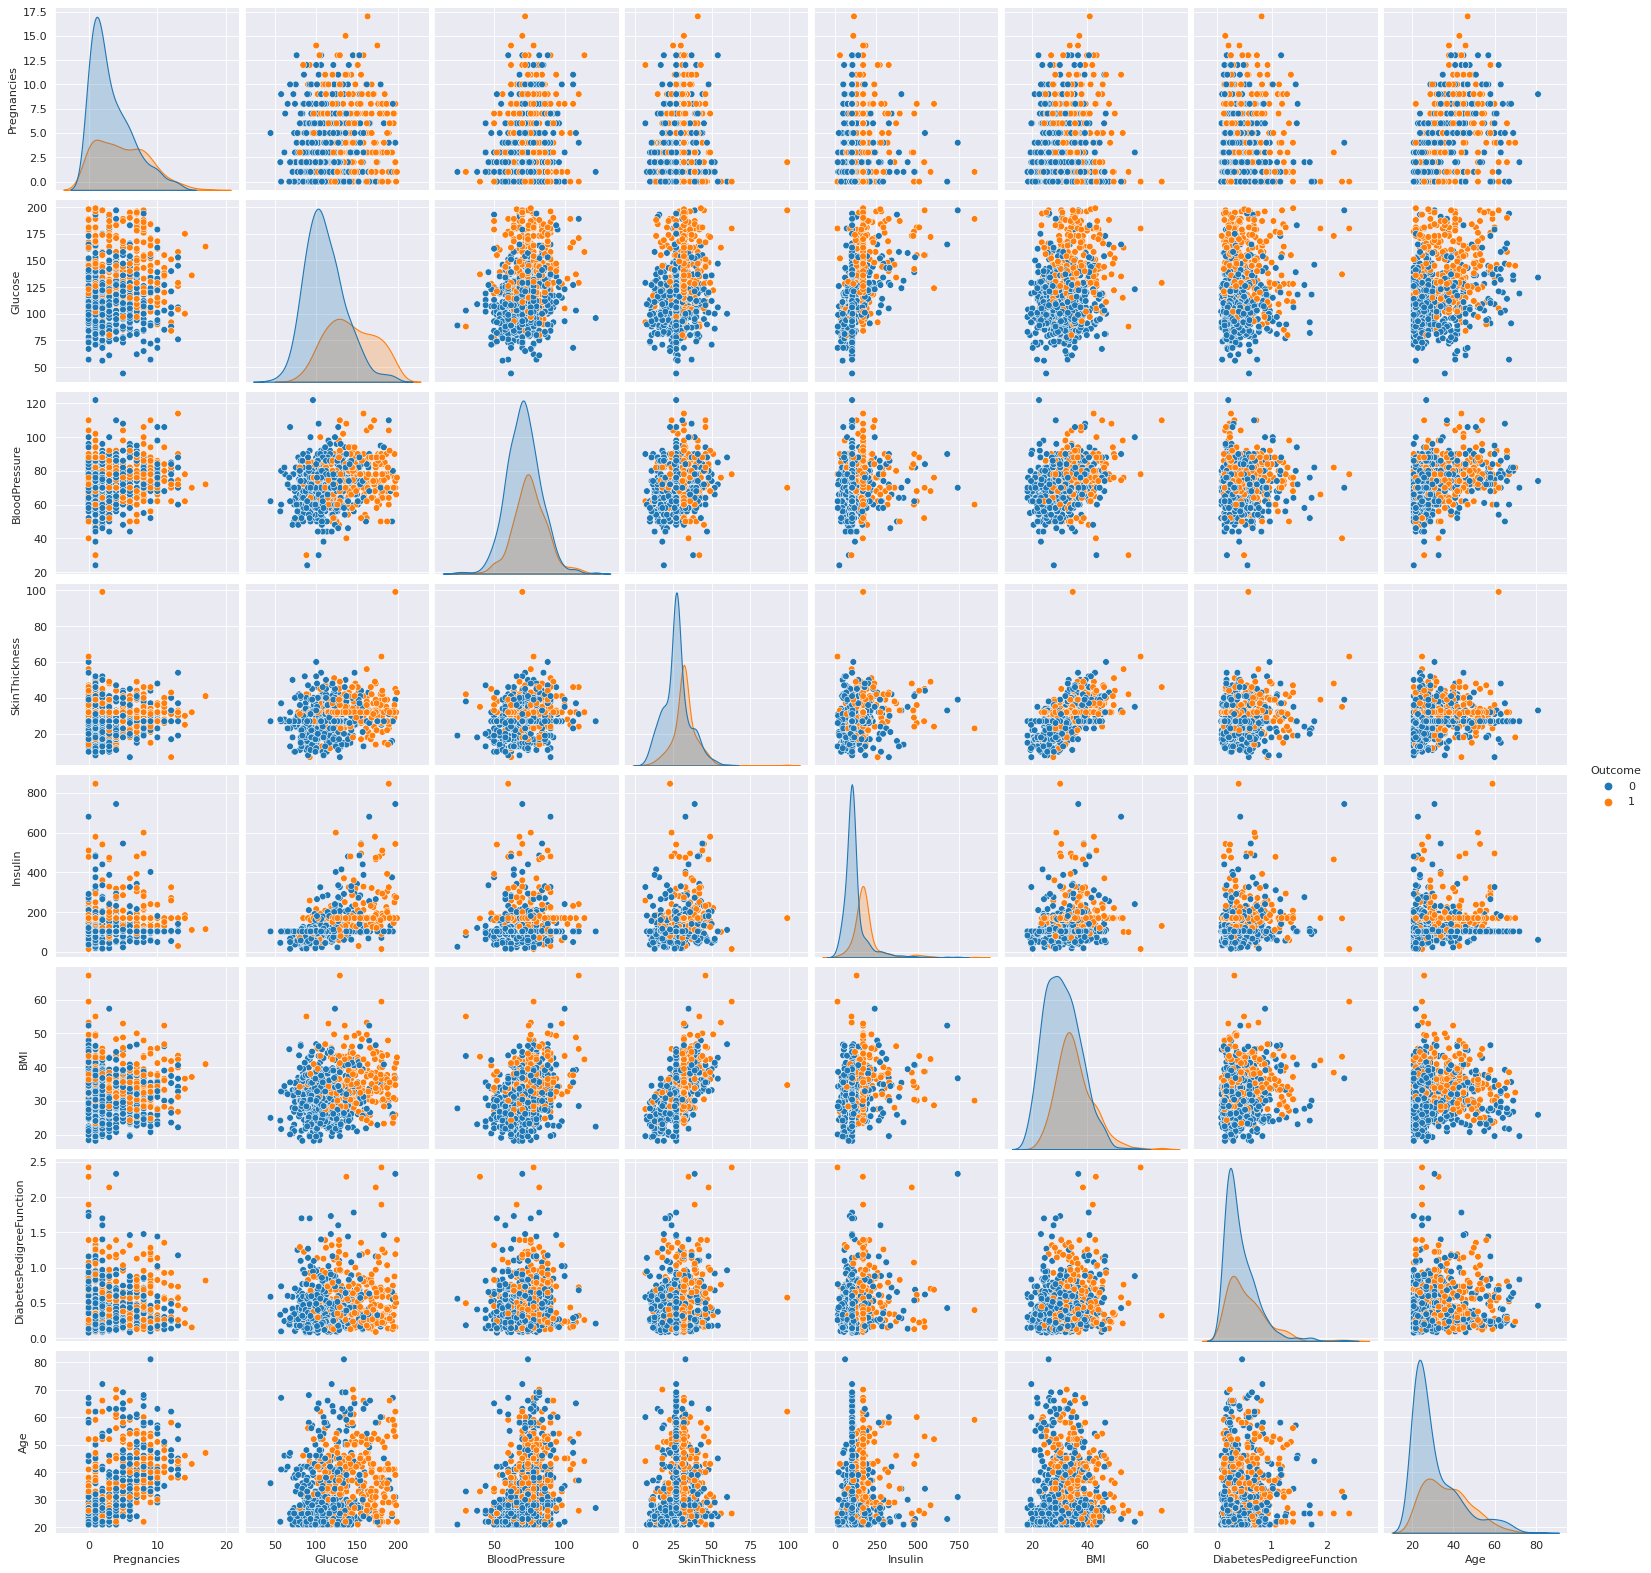

In [28]:
sns.pairplot(data, hue="Outcome")
plt.show()

### Final Check for Null Values in Data

In [29]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

# Prepare Dataset

In [30]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [31]:
X = data.drop("Outcome", axis=1).values
y = data.Outcome

## Splitting the dataset into the Training set and Test set

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Feature Scaling - Scaling Data for Some Models

In [33]:
sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

# Machine Learning - Multiple Model Testing

## Dataframe to store all the accuracy scores for Comparison and Analysis

In [34]:
MLA_compare = pd.DataFrame()

def MLA_testing(MLA, X_train, X_test):
    row_index = 0
    for classifier in MLA:
        classifier.fit(X_train, y_train)

        y_pred = classifier.predict(X_test)
        classifier_accuracy_score = accuracy_score(y_test, y_pred)

        kfold_accuracy = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)

        MLA_name = classifier.__class__.__name__
        MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
        MLA_compare.loc[row_index, 'Accuracy Score'] = classifier_accuracy_score*100
        MLA_compare.loc[row_index, 'K-Fold Accuracy'] = kfold_accuracy.mean()*100

        print(MLA_name, "Done")
        row_index+=1

In [35]:
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    XGBClassifier(eval_metric="logloss", use_label_encoder=False),
    CatBoostClassifier()  
    ]

MLA_testing(MLA=MLA, X_train=X_train, X_test=X_test)

AdaBoostClassifier Done
BaggingClassifier Done
ExtraTreesClassifier Done
GradientBoostingClassifier Done
RandomForestClassifier Done
GaussianProcessClassifier Done
PassiveAggressiveClassifier Done
RidgeClassifierCV Done
SGDClassifier Done
Perceptron Done
BernoulliNB Done
GaussianNB Done
KNeighborsClassifier Done
SVC Done
NuSVC Done
DecisionTreeClassifier Done
ExtraTreeClassifier Done
LinearDiscriminantAnalysis Done
QuadraticDiscriminantAnalysis Done
XGBClassifier Done
Learning rate set to 0.008365
0:	learn: 0.6844120	total: 52.7ms	remaining: 52.7s
1:	learn: 0.6774760	total: 55.1ms	remaining: 27.5s
2:	learn: 0.6705629	total: 56.6ms	remaining: 18.8s
3:	learn: 0.6636366	total: 57.8ms	remaining: 14.4s
4:	learn: 0.6572408	total: 58.9ms	remaining: 11.7s
5:	learn: 0.6489694	total: 60.1ms	remaining: 9.95s
6:	learn: 0.6419597	total: 61.1ms	remaining: 8.67s
7:	learn: 0.6346712	total: 62.2ms	remaining: 7.71s
8:	learn: 0.6285284	total: 63.3ms	remaining: 6.97s
9:	learn: 0.6227900	total: 64.4ms	rema

In [36]:
# Scaled Data Used Here
MLA = [    
    #GLM
    linear_model.LogisticRegressionCV(),
    
    #SVM
    svm.LinearSVC(max_iter=10000), 
]
MLA_testing(MLA=MLA, X_test=X_test_scaled, X_train=X_train_scaled)

LogisticRegressionCV Done
LinearSVC Done


# Comparing Models

## Top 10 Best Performing Models

In [37]:
MLA_compare = MLA_compare.sort_values(by="Accuracy Score", ascending=False).reset_index(drop=True)[:10]
MLA_compare

,MLA Name,Accuracy Score,K-Fold Accuracy
0,RandomForestClassifier,90.909091,87.284506
1,CatBoostClassifier,90.259740,88.593337
2,GradientBoostingClassifier,89.610390,87.617663
3,XGBClassifier,89.610390,88.098889
4,KNeighborsClassifier,89.610390,83.202010
5,ExtraTreesClassifier,87.662338,86.652565
6,NuSVC,87.012987,82.559492
7,SVC,87.012987,83.696457
8,DecisionTreeClassifier,82.467532,82.564781
9,GaussianProcessClassifier,81.818182,83.868324


#### CatBoostClassifier Performed the Best with 90.26% Accuracy and 88.6% CrossVal-Accuracy

# Using CatBoostClassifier

In [38]:
classifier = CatBoostClassifier()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)

Learning rate set to 0.008365
0:	learn: 0.6844120	total: 1.49ms	remaining: 1.49s
1:	learn: 0.6774760	total: 3.03ms	remaining: 1.51s
2:	learn: 0.6705629	total: 4.53ms	remaining: 1.5s
3:	learn: 0.6636366	total: 6.02ms	remaining: 1.5s
4:	learn: 0.6572408	total: 7.49ms	remaining: 1.49s
5:	learn: 0.6489694	total: 8.9ms	remaining: 1.48s
6:	learn: 0.6419597	total: 10.3ms	remaining: 1.47s
7:	learn: 0.6346712	total: 11.8ms	remaining: 1.46s
8:	learn: 0.6285284	total: 13.3ms	remaining: 1.46s
9:	learn: 0.6227900	total: 14.7ms	remaining: 1.45s
10:	learn: 0.6163972	total: 16.1ms	remaining: 1.45s
11:	learn: 0.6104412	total: 17.5ms	remaining: 1.44s
12:	learn: 0.6055525	total: 18.9ms	remaining: 1.44s
13:	learn: 0.5986062	total: 20.3ms	remaining: 1.43s
14:	learn: 0.5920102	total: 21.8ms	remaining: 1.43s
15:	learn: 0.5860928	total: 23.2ms	remaining: 1.43s
16:	learn: 0.5808766	total: 24.6ms	remaining: 1.42s
17:	learn: 0.5760516	total: 26ms	remaining: 1.42s
18:	learn: 0.5711514	total: 27.5ms	remaining: 1.4

Test Accuracy :  0.9025974025974026 

Confusion Matrix 
 [[97 10]
 [ 5 42]] 



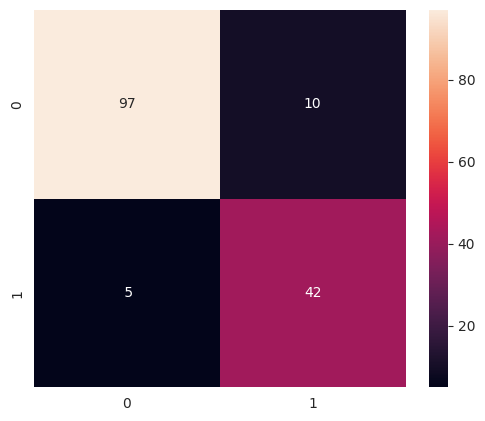

In [39]:
print("Test Accuracy : ", accuracy, "\n")

print("Confusion Matrix \n", cm, "\n")

plt.rcParams["figure.figsize"] = (6, 5)
plt.rcParams["figure.dpi"] = (100)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='2.0f')
plt.show()

# Credits
#### https://www.kaggle.com/vincentlugat/pima-indians-diabetes-eda-prediction-0-906